In [4]:
!pip install torch torchvision opencv-python
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7
!powershell -command "Invoke-WebRequest -Uri https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt -OutFile yolov7.pt"

# Go back to the original directory
%cd ..

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
C:\Users\ASUS\21MIA1062\yolov7


fatal: destination path 'yolov7' already exists and is not an empty directory.


C:\Users\ASUS\21MIA1062


In [2]:
# Import required libraries
import cv2
import numpy as np
import torch
import sys
sys.path.append('./yolov7')
from models.experimental import attempt_load
from utils.general import non_max_suppression, scale_coords
from utils.torch_utils import select_device
from IPython.display import display, clear_output
from PIL import Image


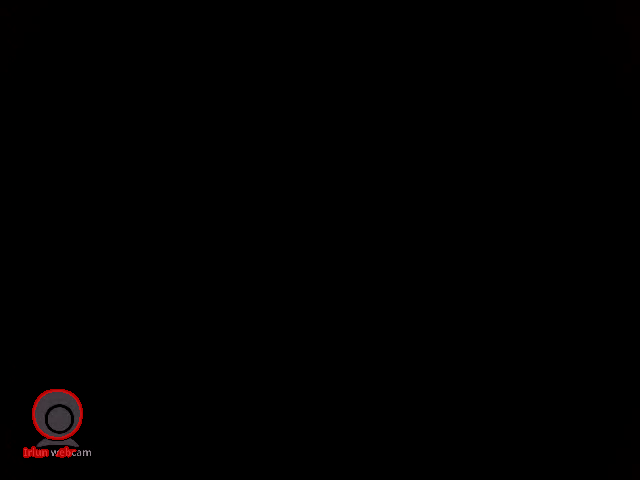


KeyboardInterrupt



In [3]:
def detect_lines_and_curves(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
    
    # Detect curves
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    for contour in contours:
        if len(contour) > 50:  # Filter small contours
            cv2.drawContours(image, [contour], 0, (0, 0, 255), 2)
    
    return image

def detect_objects(image, model, device):
    img = torch.from_numpy(image).to(device)
    img = img.permute(2, 0, 1).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    pred = model(img)[0]
    pred = non_max_suppression(pred, 0.25, 0.45, classes=None, agnostic=False)

    objects_detected = False
    for det in pred:
        if len(det):
            objects_detected = True
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], image.shape).round()
            for *xyxy, conf, cls in reversed(det):
                label = f'{model.names[int(cls)]} {conf:.2f}'
                cv2.rectangle(image, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (255, 0, 0), 2)
                cv2.putText(image, label, (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return image, objects_detected

# Load YOLOv7 model
device = select_device('')
model = attempt_load('yolov7/yolov7.pt', map_location=device)

# Main processing loop
cap = cv2.VideoCapture(0)  # Use 0 for webcam or provide video file path

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Detect lines and curves
    frame_with_lines_curves = detect_lines_and_curves(frame.copy())
    
    # Detect objects
    frame_with_objects, objects_detected = detect_objects(frame, model, device)
    
    # Combine results
    combined_frame = cv2.addWeighted(frame_with_lines_curves, 0.7, frame_with_objects, 0.3, 0)
    
    if objects_detected:
        cv2.putText(combined_frame, "STOP", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Convert BGR to RGB
    rgb_frame = cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB)
    
    # Display the result
    clear_output(wait=True)
    display(Image.fromarray(rgb_frame))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):qqqqq
        break

cap.release()
cv2.destroyAllWindows()